In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d

import alphashape as ap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 150

import pandas as pd
from colour import Color
import os

import vis.Visualization as visual
import vis.CommunityWise as cwise

from datetime import datetime

import networkx as nx
import community as community_louvain

In [2]:
# Now read in the data
locationFile = 'Location_20.csv'
communityFolder = 'communities'
dataFrame = pd.read_csv(locationFile)

# Read in the different communities we have
communityFiles = os.listdir(communityFolder)
communityArr = []
for file in communityFiles:
    if 'csv' in file:
        currComm = np.genfromtxt(f'{communityFolder}/{file}', dtype='int')
        # Make sure that we have a continuous set of integer labels for our communities
        # ie take [1, 4, 7, 3, 2, 6] -> [0, 3, 5, 2, 1, 4]
        currComm = cwise.patchCommunityIndices(currComm)
        # Now make sure we don't have empty communities
        # and that they are the same length as our position data
        # I am not sure why there are entries that aren't the same length...
        #if np.sum(currComm) != 0 and len(currComm) == len(dataFrame["x"]):
        communityArr.append(currComm)
        
#communityArr = np.array(communityArr)

#print(len(np.unique([len(communityArr[i]) for i in range(len(communityArr))])))

# Generate the voronoi tesselation
points = np.zeros([len(dataFrame["x"]), 2])
points[:,0] = dataFrame["x"]
points[:,1] = dataFrame["y"]

mapVor = Voronoi(points)

testCommunities = [0, 2, 10]

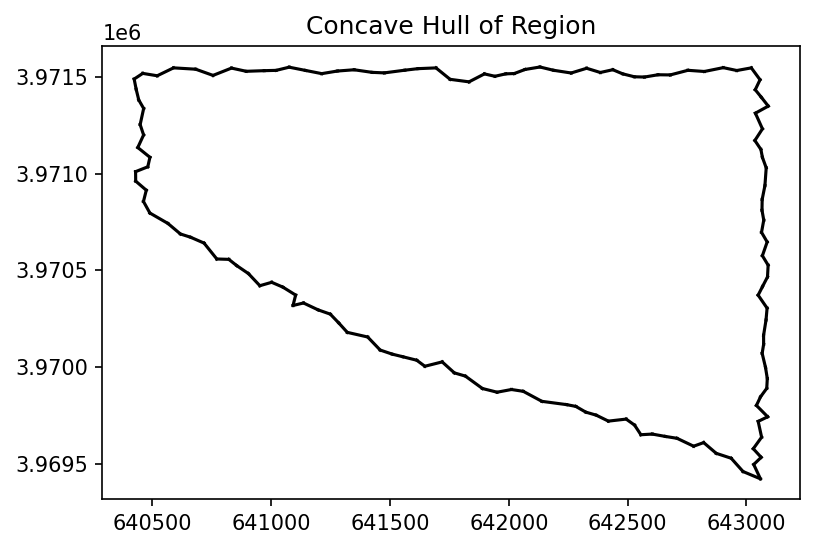

In [3]:
hullLines, hullLineCommunities = cwise.concaveHull(points, communityArr[0])

# And draw the hull
fig, ax = plt.subplots()
visual.drawLines(ax, hullLines)
plt.title("Concave Hull of Region")
plt.show()

In [4]:
# Now draw five detections as a sample
hullLineCommunities = [cwise.findConcaveHullComunities(points, hullLines, communityArr[i]) for i in testCommunities]
communityBoundaries = [cwise.vorToCommunityBounds(mapVor, communityArr[testCommunities[i]], hullLines, hullLineCommunities[i]) for i in range(len(testCommunities))]

# # Now show everything
# fig, ax = plt.subplots(1, len(testCommunities), figsize=(15, 3))

# randomColors = [visual.genRandomColors(max(communityArr[i])) for i in testCommunities]

# for i in range(len(testCommunities)):
#     # Plot the points
#     visual.drawPoints(ax[i], points, communityArr[testCommunities[i]], randomColors[i], s=5)
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
    
# plt.savefig('images/initial_communities.png')
# plt.show()


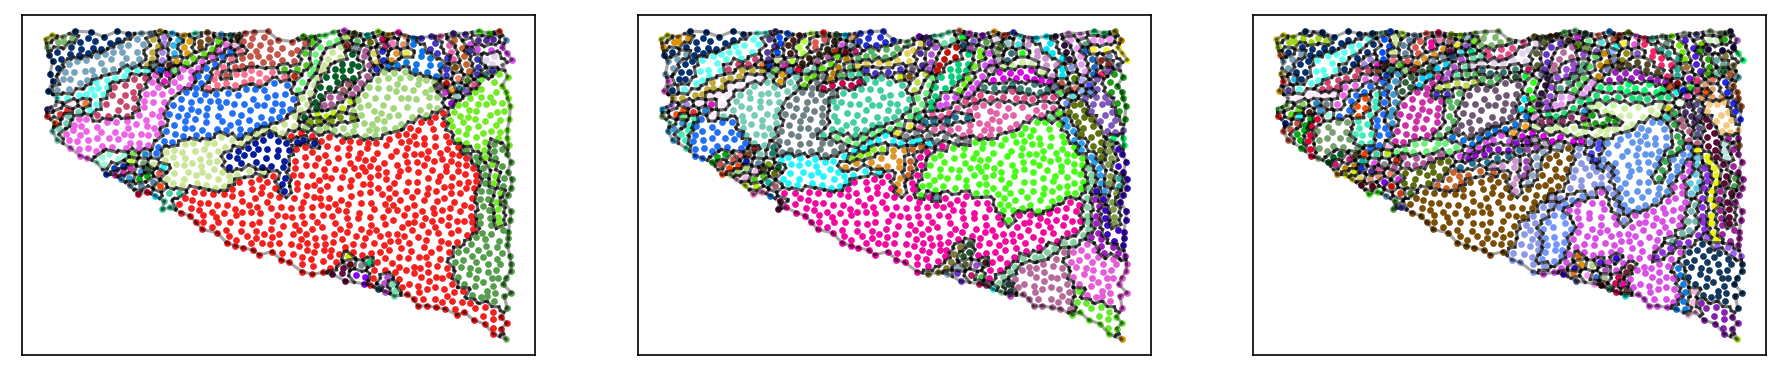

In [24]:
# Draw the boundaries for specific comminities
fig, ax = plt.subplots(1, len(testCommunities), figsize=(15, 3))

for i in range(len(testCommunities)):
    for j in range(len(communityBoundaries[i])):
        visual.drawLines(ax[i], communityBoundaries[i][j], 'black', opacity=.35)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    visual.drawPoints(ax[i], points, communityArr[testCommunities[i]], randomColors[i], s=5)

plt.savefig('images/initial_tessellation.png')
plt.show()

In [5]:
# Now we create a uniform grid and determine which points are in which communities
gridPoints = 65

uniformX = np.linspace(min(points[:,0]), max(points[:,0]), gridPoints)
uniformY = np.linspace(min(points[:,1]), max(points[:,1]), gridPoints)

uniformGridPoints = np.zeros([gridPoints, gridPoints, 2])

for i in range(gridPoints):
    for j in range(gridPoints):
        uniformGridPoints[i,j] = [uniformX[i], uniformY[j]]
        
uniformGridPoints = uniformGridPoints.reshape([gridPoints*gridPoints, 2])

assignedPoints = []
assignedCommunities = []
for i in range(len(testCommunities)):
    currAssignedPoints, currAssignedCommunities = cwise.assignCommunities(uniformGridPoints, communityBoundaries[i], hullLines)
    
    assignedPoints.append(currAssignedPoints)
    assignedCommunities.append(currAssignedCommunities)

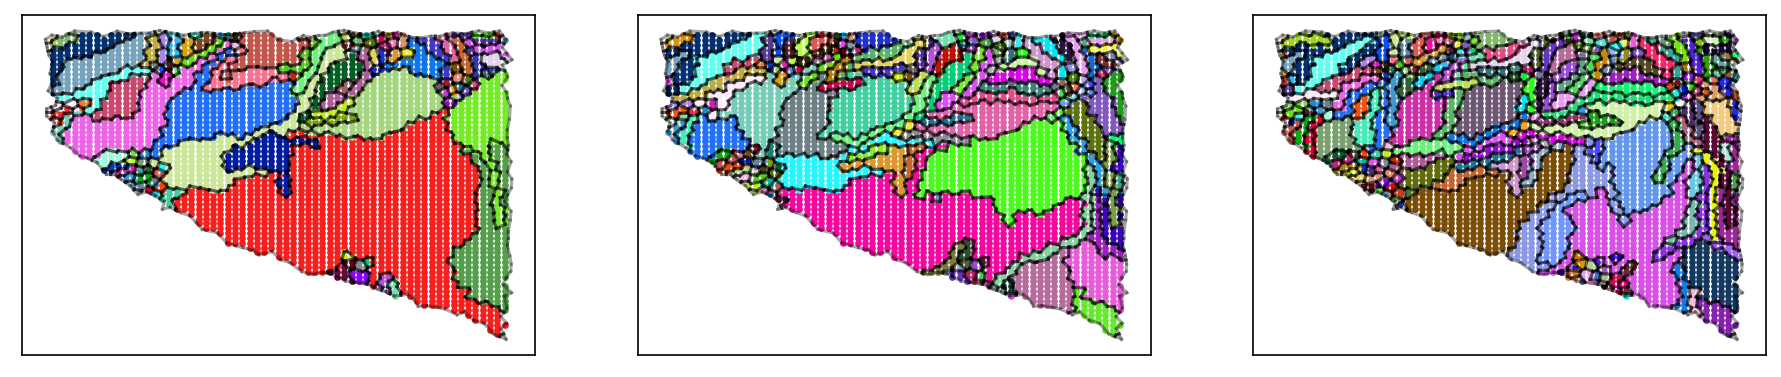

In [26]:
# Draw the boundaries for specific comminities
fig, ax = plt.subplots(1, len(testCommunities), figsize=(15, 3))

for i in range(len(testCommunities)):
    for j in range(len(communityBoundaries[i])):
        visual.drawLines(ax[i], communityBoundaries[i][j], 'black', opacity=.35)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    visual.drawPoints(ax[i], assignedPoints[i], assignedCommunities[i], randomColors[i], s=5)

plt.savefig('images/normalized_communities.png')
plt.show()

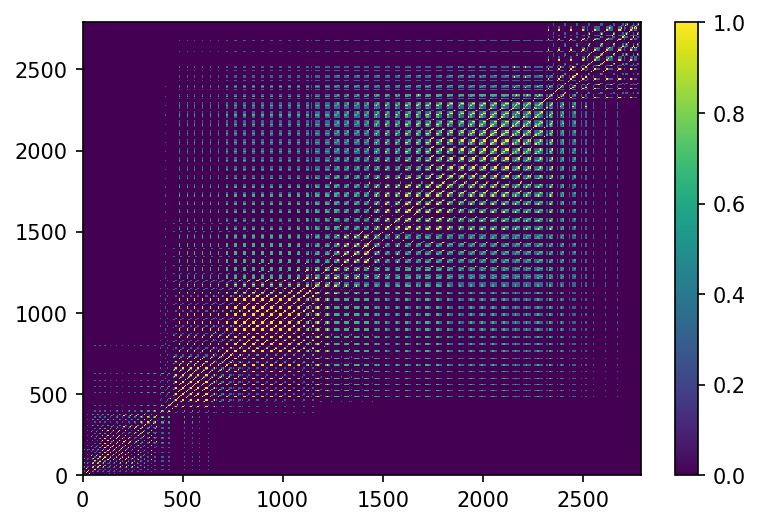

In [9]:
# Create the adjacency matrix
def calculateConsensusMatrix(communityAssignments):
    # Mostly just for testing, so I can use a single community detection
    if len(np.shape(communityAssignments)) == 1:
        communityAssignments = [communityAssignments]
        
    numPoints = len(communityAssignments[0])
    consensusMatrix = np.zeros([numPoints, numPoints])
    
    # Iterate over every detection
    # Quite inefficient, but very simple at least
    for i in range(len(communityAssignments)):
        for j in range(numPoints):
            for k in range(numPoints):
                consensusMatrix[j,k] += int(communityAssignments[i][j] == communityAssignments[i][k])
    
    
    return consensusMatrix/len(communityAssignments)

consensusMatrix = calculateConsensusMatrix(assignedCommunities)

plt.pcolor(consensusMatrix)
plt.colorbar()
plt.savefig('images/consensus_matrix.png')
plt.show()

In [12]:
# Now we can create a graph from the consensus matrix
graph = nx.from_numpy_matrix(consensusMatrix)
finalPoints = assignedPoints[0]

# And perform the community detection
# .7 is pretty arbitrary here, I need to ask Vrinda what she uses
# I think she also mentioned she's modified genlouvain a little, so this
# might not be exactly the same
partition = community_louvain.best_partition(graph, resolution=.7, randomize=True)
partition = list(partition.values())

finalVor = Voronoi(finalPoints)

In [13]:
finalHull, finalHullCommunities = cwise.concaveHull(finalPoints, partition)
finalCommunityBounds = cwise.vorToCommunityBounds(finalVor, partition, finalHull, finalHullCommunities)

/home/jack/workspaces/jupyter-workspace/CommunityDetectionVis/vis/CommunityWise.py:148: RuntimeWarning: invalid value encountered in double_scalars
  lineSlope = (nonInfinitePoint[1] - nodeMidpoint[1]) / (nonInfinitePoint[0] - nodeMidpoint[0])
/home/jack/workspaces/jupyter-workspace/CommunityDetectionVis/vis/CommunityWise.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  lineSlope = (nonInfinitePoint[1] - nodeMidpoint[1]) / (nonInfinitePoint[0] - nodeMidpoint[0])
/home/jack/workspaces/jupyter-workspace/CommunityDetectionVis/vis/CommunityWise.py:155: RuntimeWarning: invalid value encountered in double_scalars
  lineSlope*(nonInfinitePoint[0] + np.sign(nodeMidpoint[0] - nonInfinitePoint[0])*1000) + lineIntercept]


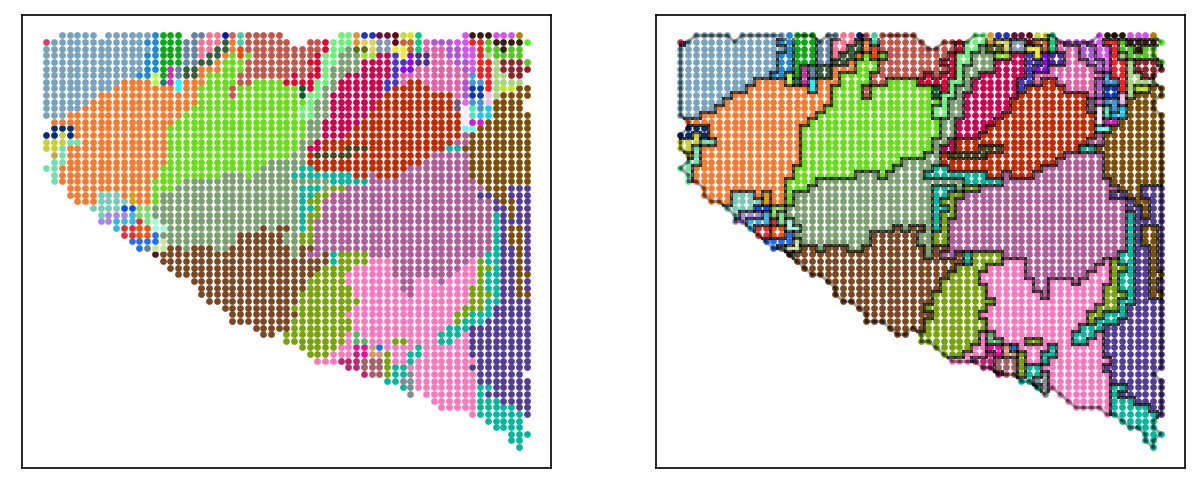

In [16]:
# Now show everything
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

finalRandomColors = visual.genRandomColors(max(partition)+1)

# Plot the points
visual.drawPoints(ax[0], finalPoints, partition, finalRandomColors, s=5)

for j in range(len(finalCommunityBounds)):
    visual.drawLines(ax[1], finalCommunityBounds[j], 'black', opacity=.35)
    
visual.drawPoints(ax[1], finalPoints, partition, finalRandomColors, s=5)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.savefig('images/consensus_result.png')
plt.show()

In [62]:
# Create a structured array so sorting works
structuredPoints = [np.array([(assignedPoints[j][i,0], assignedPoints[j][i,1]) for i in range(len(assignedPoints[0]))], dtype=[('x', float), ('y', float)]) for j in range(3)]
print(structuredPoints)
order = np.argsort(structuredPoints, order=('x', 'y'))

[array([(641173.72999758, 3970320.21574833),
       (641173.72999758, 3970353.46983049),
       (641173.72999758, 3970386.72391266), ...,
       (642216.23687553, 3971417.60045982),
       (642758.34045206, 3971118.31372033),
       (642758.34045206, 3971151.56780249)],
      dtype=[('x', '<f8'), ('y', '<f8')]), array([(641090.32944734, 3970419.97799483),
       (641132.02972246, 3970353.46983049),
       (641132.02972246, 3970419.97799483), ...,
       (642216.23687553, 3971417.60045982),
       (642758.34045206, 3971118.31372033),
       (642758.34045206, 3971151.56780249)],
      dtype=[('x', '<f8'), ('y', '<f8')]), array([(641924.3349497 , 3969887.91268016),
       (641966.03522482, 3969887.91268016),
       (642007.73549994, 3969887.91268016), ...,
       (642007.73549994, 3970419.97799483),
       (642174.53660041, 3971417.60045982),
       (642216.23687553, 3971417.60045982)],
      dtype=[('x', '<f8'), ('y', '<f8')])]


In [8]:
print(assignedPoints[0][123])
print(assignedPoints[1][123])

[ 640673.32669616 3971051.80555599]
[ 640673.32669616 3971051.80555599]
